# Check Library Version

In [1]:
import warnings
import os
import sys

import numpy as np

import cv2

import keras
import tensorflow as tf

warnings.filterwarnings('ignore')

print('python :', sys.version)
print('')

print('numpy :', np.__version__)
print('')

print('opencv :', cv2.__version__)
print('')

print('keras :', keras.__version__)
print('tf :', tf.__version__)

python : 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]

numpy : 1.18.5

opencv : 4.3.0

keras : 2.4.3
tf : 2.2.0


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5051238267979741319,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 23600668042683820
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3133590732
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2010579994338439819
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7989568772799005611
 physical_device_desc: "device: XLA_GPU device"]

# Setting Path

In [3]:
ROOT_DIR = os.path.abspath('./')
models_path = os.path.join(ROOT_DIR, 'models')
weights_path = os.path.join(models_path, 'weights')

best_model_file = os.path.join(models_path, '20200727T1326_model.json')
best_weight_file = os.path.join(weights_path, '20200728T1627_0212_0.0102.hdf5')

print("base models path :", models_path)

base models path : C:\Users\daumsoft\Jupyter Notebook\daumsoft\LH Digital Twin Develop\스카이라인\Skyline-Detection\models


# Make directory

In [4]:
if not os.path.isdir(models_path):
    os.makedirs(models_path)
if not os.path.isdir(weights_path):
    os.makedirs(weights_path)

# Load Model

In [1]:
from keras.models import model_from_json 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
import keras.backend as K

K.clear_session()
K.set_image_data_format('channels_last')
K.set_floatx('float64')

json_file = open(best_model_file, "r")
loaded_model_json = json_file.read() 
json_file.close()

unet = model_from_json(loaded_model_json)
unet.load_weights(best_weight_file)

unet.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['mse', 'mae'])

NameError: name 'best_model_file' is not defined

# Predict Test Image

In [6]:
from PIL import Image, ImageDraw

def img_prediction(img_path, model):
    img = Image.open(img_path).convert('L')
    
    input_arr = np.array(img.resize((256, 256)))/255
    input_arr = input_arr.reshape((1, ) + input_arr.shape)
    
    predictions = model.predict(input_arr)
    predictions = np.array(np.round(predictions[0] * 255, 0), dtype = 'int')
    
    return img, predictions

In [7]:
img_path = './images/samples/test.jpg'

input_img, prediction = img_prediction(img_path, unet)

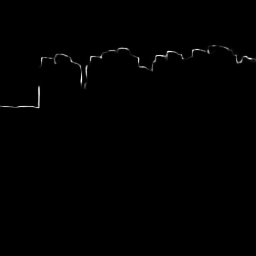

In [8]:
# 조망차폐율에 쓸꺼
array_to_img(prediction)

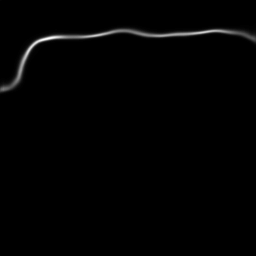

In [185]:
# 20200728T1012_0103_0.0150
array_to_img(prediction)

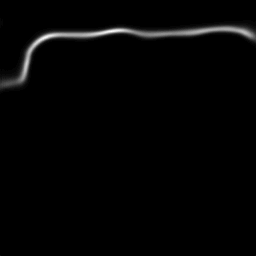

In [160]:
# loss0.0167
array_to_img(prediction)

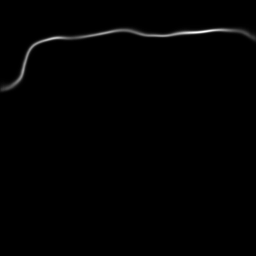

In [191]:
# loss0.0142
array_to_img(prediction)

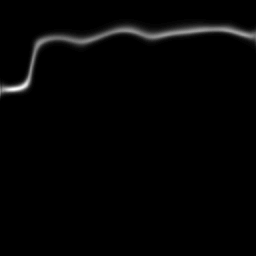

In [35]:
# loss0.0211
array_to_img(prediction)

In [9]:
def clear_img(img, threshold = 40):
    '''
    img는 array
    '''
    clear = np.where(img < threshold, 0, img)
    clear = np.where(clear > 0, 255, clear)
    
    return clear

In [16]:
clear_pred = clear_img(prediction, 20)

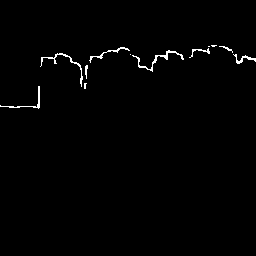

In [17]:
#array만 save 가능
array_to_img(clear_pred)

In [18]:
def y_ridge(img):
    cols = img.shape[1]
    rows = img.shape[0]

    ridge = []

    for c in range(cols):
        for r in range(rows):
            row = img[r][c]
            if row > 0:
                ridge.append([c, r])
                break

    ridge_array = np.array(ridge)
    
    return ridge_array

In [19]:
ridge = y_ridge(clear_pred)

In [20]:
def draw_polylines(img, ridge):
    
    col = img.shape[1]
    row = img.shape[0]
    
    canvas = np.zeros((col, row, 3), np.uint8)
    ridge = ridge.astype(np.int32)
    
    polyline_img = cv2.polylines(canvas, [ridge], False, (255, 0, 0))
    
    return polyline_img

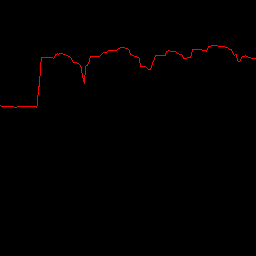

In [21]:
array_to_img(draw_polylines(clear_pred, ridge))

In [22]:
def draw_skyline(img, ridge):
    
    ridge = ridge.astype(np.int32)
    
    polyline_img = cv2.polylines(img, [ridge], False, (255, 0, 0))
    
    return polyline_img

In [23]:
resize_img = np.array(input_img.resize((256,256)), np.uint8)

In [24]:
output_img = draw_skyline(resize_img, ridge).reshape((256,256, 1))

In [25]:
img_result = cv2.resize(resize_img, dsize = (input_img.size[0], input_img.size[1]), interpolation=cv2.INTER_AREA)

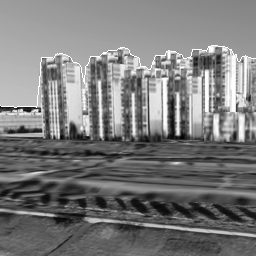

In [26]:
array_to_img(output_img)